In [13]:
import pandas as pd
import numpy as np
import cvxpy as cp
# import mosek
import pickle
from pandas.tseries.offsets import BMonthEnd
from time import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PerformanceMetrics import *

import seaborn as sns

In [4]:
ff_factors = pd.read_csv('data/F-F_Research_Data_Factors_Monthly.csv',index_col=0)
ff_factors.index = pd.to_datetime(ff_factors.index)

ff_factors = ff_factors.reset_index()
cols = list(ff_factors.columns)
cols[0]='Date'
ff_factors.columns = cols

ff_factors.tail(5)

,Date,Mkt-RF,SMB,HML,RF
1150,2022-05-31,-0.0034,-0.0185,0.0841,0.0003
1151,2022-06-30,-0.0843,0.0209,-0.0597,0.0006
1152,2022-07-29,0.0957,0.0281,-0.0410,0.0008
1153,2022-08-31,-0.0378,0.0139,0.0031,0.0019
1154,2022-09-30,-0.0936,-0.0081,0.0005,0.0019


In [5]:
n = 2000

# Get the excess returns data
idx = pd.read_csv('data/TOP{}_universe.csv'.format(n), parse_dates=[0])
idx = idx[idx['date'] >= '1970-01-01'].reset_index(drop = True)

returndata = pd.read_csv('data/crspmsf.csv', index_col = 0)[['date', 'permno', 'ret']]
returndata['date'] = pd.to_datetime( returndata['date'] )
returndata['permno'] = returndata['permno'].astype(int)
returndata = returndata[returndata['date'] >= '1970-01-01'].reset_index(drop = True)
returndata['date'] = pd.to_datetime(returndata['date']) - pd.tseries.offsets.MonthBegin() + pd.tseries.offsets.BMonthEnd()

betaData = pd.read_csv('data/return_pf_excess_ret_beta.csv', index_col = 0)[['date','permno' ,'beta_30']]
betaData['date'] = pd.to_datetime(betaData['date'],format='%Y%m') + BMonthEnd()
betaData = betaData[betaData['date'] >= '1970-01-01'].reset_index(drop = True)


with open('data/exalpha_beta_30.pkl', 'rb') as f:
    data = pickle.load(f)

print(idx.head())
print(data.head())
print(returndata.head())

universe = pd.read_csv(f'data/TOP2000_universe.csv',parse_dates=[0],index_col=0)
universe500 = pd.read_csv(f'data/TOP500_universe.csv',parse_dates=[0],index_col=0)
ff_loadings = pd.read_pickle('data/ffloadings_halflife36_TOP2000.pkl')
ff_cov_df = pd.read_pickle(f'data/ff_cov_halflife{36}.pkl')
spec_est = pd.read_pickle(f'data/spec_est_halflife{36}_TOP{2000}.pkl')

def risk_cov(date):
    ff_cols = ['Mkt-RF','HML','SMB']
    betas = ff_loadings.loc[date,(universe.loc[date],slice(None))].unstack()[ff_cols].dropna(axis=0)
    ff_cov = ff_cov_df.loc[date].loc[ff_cols,ff_cols]
    spec_cov = spec_est.loc[date]
    
    idx = spec_cov.index.intersection(betas.index)
    spec_cov = spec_cov.reindex(idx)
    betas = betas.reindex(idx)

    cov = betas@ff_cov@betas.T + np.diag(spec_cov)
    return cov

        date      0      1      2      3      4      5      6      7      8  \
0 1970-01-30  12490  10401  12079  11754  11850  14322  27983  14736  12060   
1 1970-02-27  12490  10401  12079  11754  11850  14322  14736  27983  12060   
2 1970-03-31  12490  10401  12079  11850  11754  14322  14736  27983  12060   
3 1970-04-30  12490  10401  12079  11850  11754  14322  14736  27983  12060   
4 1970-05-29  12490  10401  12079  11850  11754  14322  14736  27983  12060   

   ...   1990   1991   1992   1993   1994   1995   1996   1997   1998   1999  
0  ...  48661  31480  41304  40256  48573  48899  45460  35246  44177  37444  
1  ...  43174  46711  34331  49998  35051  41304  43406  46519  45823  38340  
2  ...  33582  46500  35641  49429  37612  36644  36695  33830  44943  41574  
3  ...  47618  31106  46498  44804  32459  47407  31819  41574  37989  47685  
4  ...  31595  32440  31106  14197  42876  44513  32133  39132  48848  43537  

[5 rows x 2001 columns]
date        permno
1970-01

In [6]:
def FactorMimickingPortOpt_MV(alpha, beta, gamma, V):
    '''
    output the optimal weights for the factor mimicking portfolio
    - only constraint is beta neutral 
    '''
    n = V.shape[0]
    x = cp.Variable(n)
    
    obj = cp.Maximize(x.T@alpha - gamma/2*cp.quad_form(x,V))
    constraints = [x.T@beta == 0]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.GUROBI)
    return x.value, prob.value

def FactorMimickingPortOpt_SR(alpha, beta, V, indiv_alpha_contrib=0.1):
    '''
    output the optimal weights for the factor mimicking portfolio
    - only constraint is beta neutral 
    '''

    # try:

    n = V.shape[0]
    z = cp.Variable(n)
    kappa = cp.Variable(1)

    alpha = alpha.reshape(alpha.shape[0])
    V = cp.atoms.affine.wraps.psd_wrap(V)

    obj = cp.Minimize(cp.quad_form(z,V))

    # ORIGINAL CONSTRAINT: SUM(X)==1 CONSTRAINT IS NOT APPLICABLE
    # constraints = [z.T@beta == 0, z.T@alpha == 1, np.ones(n)@z-kappa==0, kappa>=0, ]
    # FIRST UPDATED CONSTRAINT: WORKS BUT CAN LEAD TO CONCENTRATED PORTFOLIOS
    # constraints = [z.T@beta == 0, z.T@alpha == 1 ]
    # NEW UPDATED CONSTRAINT: LIMIT EACH POSITION'S ALPHA CONTRIBUTION TO A CONSTANT VALUE
    constraints = [z.T@beta == 0, z.T@alpha == 1, cp.multiply(z,alpha) <= indiv_alpha_contrib]
    prob = cp.Problem(obj, constraints)
    val = prob.solve(solver=None,verbose=False)
    if z.value is None:
        raise Exception()
    #return z.value/ kappa.value 
    return z.value


In [16]:
targetVol = 0.05
fullData = dict()
noConv = 0
#for i in range(1, idx['date'].shape[0]):
#for i in tqdm(list(range(36,120))):
for i in tqdm(list(range(36, idx.shape[0] - 1))):
    start = time()

    #Loop through the dates
    specificDate = idx['date'][i]
    returnsDate = idx['date'][i+1]

    #Get the covariance matrix
    V = risk_cov(specificDate)

    #For that specific date, get the permno of the investable stocks 
    specificPermno = idx[idx['date'] == specificDate].iloc[:, 1:].T
    specificPermno.columns = ['permno']

    #Get the alphas for that specific date
    alphas = pd.DataFrame( data[specificDate]).reset_index()
    alphas['beta_30_exalpha'] = (alphas['beta_30_exalpha'] - alphas['beta_30_exalpha'].mean())/alphas['beta_30_exalpha'].std()

    #Get the betas for that specific date
    betas = betaData[betaData['date'] == specificDate]

    #merge the alphas of that date with the permno of the investable stocks
    alphas_permno = pd.merge(alphas, specificPermno, how = 'inner', on = 'permno')

    #merge the betas of that date with the permno of the investable stocks
    betas_permno = pd.merge(betas, specificPermno, how = 'inner', on = 'permno')

    #Merge the returns of that date with the permno of the investable stocks
    returns_permno = pd.merge(returndata[returndata['date'] == returnsDate].dropna(), specificPermno, how = 'inner', on = 'permno')

    #Merge, alphas, betas and returns 
    investableStocks = pd.merge(alphas_permno, betas_permno, on = 'permno', how = 'inner')
    investableStocks = pd.merge(investableStocks, returns_permno, on = 'permno', how = 'inner')
    investableStocks = pd.merge(investableStocks, universe500.loc[specificDate].rename('permno').to_frame(), on = 'permno', how = 'inner')
    investableStocks,V = investableStocks.set_index('permno').align(V,join='inner',axis=0)
    

    V = V.reindex(columns=V.index)

    # #the shape of investable stocks is not matching with the shape of V.
    # finalPermno = ''
    # if V.shape[0] < investableStocks.shape[0]:
    #     print('V smaller')
    #     finalPermno = list( V.index)
    #     invest_copy = investableStocks.set_index('permno')
    #     investableStocks = invest_copy.loc[finalPermno, :]
    # else:
    #     finalPermno = list( investableStocks.permno)
    #     V = V.loc[finalPermno, finalPermno]

    assert investableStocks.isna().sum().sum() == 0
    assert V.shape[0] == investableStocks.shape[0], 'Shape of alphas and V must match'

    shape = (investableStocks.shape[0], 1)
    alpha = investableStocks['beta_30_exalpha'].values.reshape(shape)
    beta = investableStocks['beta_30'].values.reshape(shape)
    V_np = V.values

    try:
        w = FactorMimickingPortOpt_SR(alpha, beta, V_np)
        print('sum of weights', w.sum())
        portfolioVol = np.sqrt(w.T @ V @ w)
        scaledW = (targetVol/portfolioVol) * w
        investableStocks['w'] = w
        investableStocks['scaled_w'] = scaledW
        
        #Create one column with equally weighted weights and equally weighted weights scaled
        
        #Sort values
        investableStocks = investableStocks.sort_values(by = 'beta_30')

        #get top and bottom percentiles
        perc10 = investableStocks.shape[0]//10
        perc90 = investableStocks.shape[0] - perc10

        #Define the weight of top and bottom 10%
        investableStocks['wEq'] = 0
        investableStocks.iloc[0:perc10, -1] = (1/perc10)
        investableStocks.iloc[perc90:, -1] = 1/(investableStocks.shape[0] - perc90)

        #Define winner and losser and get the betas
        winner = investableStocks.iloc[0:perc10, :]
        losser = investableStocks.iloc[perc90:, :]

        betaWinner = winner.beta_30.T @  winner.wEq
        betaLosser = losser.beta_30.T @  losser.wEq

        #Fix a proportion of the loser portfolio and find the proportion of the winner
        propLosser = -0.5
        propWinner = -(propLosser * betaLosser)/betaWinner

        #Multiply the weights by those proportions
        investableStocks.iloc[0:perc10, -1] *= propWinner
        investableStocks.iloc[perc90:, -1] *= propLosser
        
        #Scale to target vol
        portfolioVol = np.sqrt(investableStocks['wEq']@V@investableStocks['wEq'])
        investableStocks['wEqScaled'] = (targetVol/portfolioVol) * investableStocks['wEq']
        
        #Check if it is beta neutral
        print('beta of eq portfolio:', investableStocks.beta_30.values.T @ investableStocks.wEqScaled)

    except Exception as e:
        print('No convergence for', specificDate)
        print(e)
        noConv += 1
        investableStocks['w'] = np.nan
        investableStocks['scaled_w'] = np.nan
    
    fullData[specificDate] = investableStocks
    
    end = time()
    finalTime = round( (end - start)/60, 3)

    print('Iteration = {}'.format(i))
    print(finalTime, 'minutes\n')
    
print('No Convergence:', noConv)

  0%|          | 0/590 [00:00<?, ?it/s]

sum of weights 0.34164227841587197
beta of eq portfolio: -2.914335439641036e-16
Iteration = 36
0.008 minutes

sum of weights -35.65828938361949
beta of eq portfolio: 8.326672684688674e-17
Iteration = 37
0.006 minutes

sum of weights -22.440226636197036
beta of eq portfolio: -1.3183898417423734e-16
Iteration = 38
0.006 minutes

sum of weights -0.8679002327385016
beta of eq portfolio: 1.6653345369377348e-16
Iteration = 39
0.006 minutes

sum of weights -0.7610050159220824
beta of eq portfolio: -1.6653345369377348e-16
Iteration = 40
0.006 minutes

sum of weights -1.3837413378761156
beta of eq portfolio: -8.326672684688674e-17
Iteration = 41
0.006 minutes

sum of weights -1.0541312093482582
beta of eq portfolio: 1.1796119636642288e-16
Iteration = 42
0.006 minutes

sum of weights -0.42601028746537306
beta of eq portfolio: 5.551115123125783e-17
Iteration = 43
0.006 minutes

sum of weights -0.4350519351194657
beta of eq portfolio: -2.0122792321330962e-16
Iteration = 44
0.006 minutes

sum of we

In [20]:
dataForDf = []
for key, theData in fullData.items():
    
    r = theData['ret'].values
    w_scaled = theData['scaled_w'].values.T
    w_eq_scaled = theData['wEqScaled'].values.T
    oneReturn = r @ w_scaled.T
    oneReturnScaled = r @ w_eq_scaled.T
    
    dataForDf.append( (key, oneReturn, oneReturnScaled) )
    
returns = pd.DataFrame(dataForDf, columns = ['Date', 'FactorMimRetSR', 'FactorMimRetEqW'])
returns = pd.merge(returns, ff_factors, on = 'Date', how = 'left')

In [29]:
#Performance metrics
rf = returns['RF']
market = returns['Mkt-RF']
rets = returns.loc[:, ['FactorMimRetSR', 'FactorMimRetEqW']]
metrics = PerformanceMetrics(rets, rf, market)
metrics.get_metrics(annualize = 12, excessReturn = True)

,RetArith,ExcRetArith,AvgRetGeo,ExcRetGet,Vol,SR,MaxDD,Skew,ExcRetSkew,Kurt,ExcRetKurt,Annualized Alpha,Beta,IR,Alpha T value,Beta T Value,Alpha P value,Beta P Value
FactorMimRetSR,0.029681,-0.013739,-0.132184,-0.170352,0.545921,-0.025166,0.999850,0.016357,0.016495,4.159774,4.202055,-0.023179,0.130345,-0.042489,-0.295128,0.920350,0.768000,0.357767
FactorMimRetEqW,0.037252,-0.006168,0.012184,-0.030908,0.218927,-0.028172,0.835619,-0.607817,-0.598358,8.372076,8.464634,-0.009233,0.042331,-0.042196,-0.293090,0.745146,0.769557,0.456481


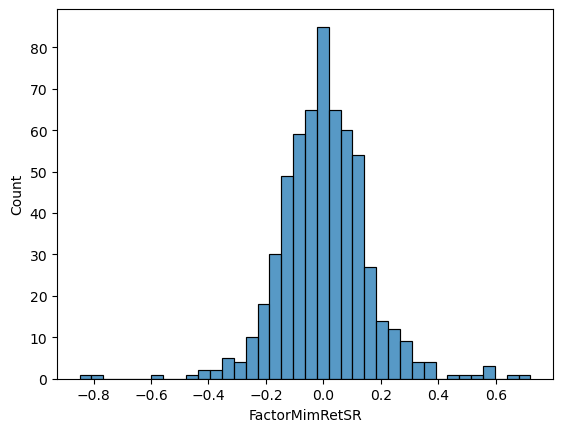

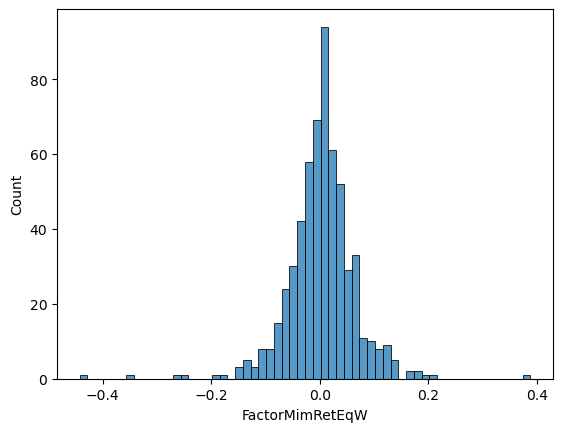

In [40]:
sns.histplot(returns['FactorMimRetSR'])
plt.show()
sns.histplot(returns['FactorMimRetEqW'])
plt.show()

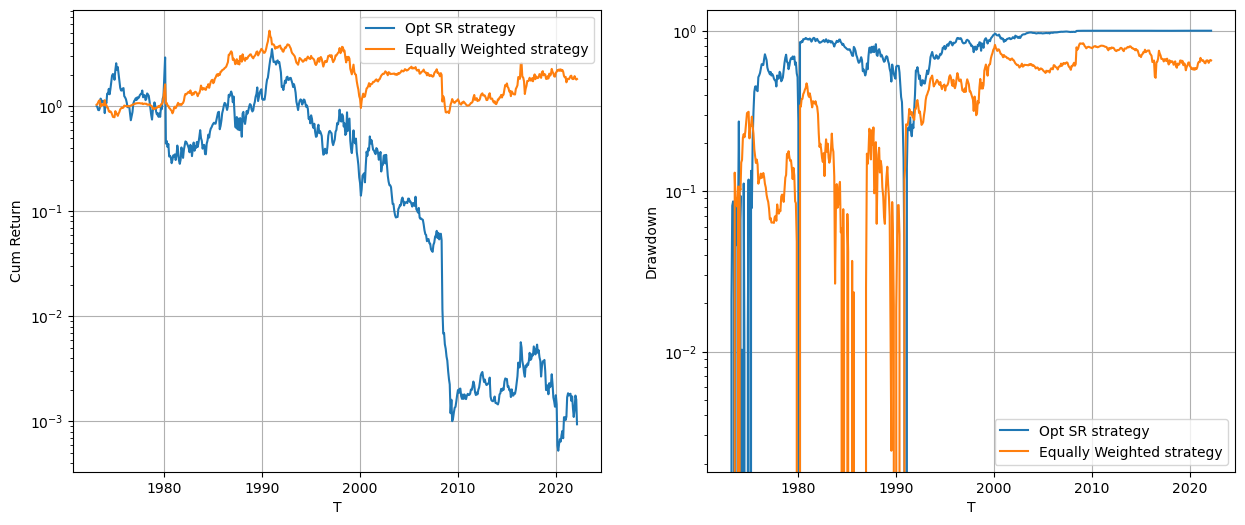

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (15,  6))
cum_ret = metrics.get_cumulativeReturn()

returns[['CumRetSR', 'CumRetEqW']] = cum_ret
returns[['DD_SR', 'DD_EqW']] = metrics.get_drawdown()

ax[0].set_yscale('log')

ax[0].plot(returns['Date'],returns['CumRetSR'], label = 'Opt SR strategy')
ax[0].plot(returns['Date'],returns['CumRetEqW'], label = 'Equally Weighted strategy')

ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('Cum Return')
ax[0].set_xlabel('T')

ax[1].set_yscale('log')
ax[1].plot(returns['Date'],returns['DD_SR'], label = 'Opt SR strategy')
ax[1].plot(returns['Date'],returns['DD_EqW'], label = 'Equally Weighted strategy')

ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('T')

plt.show()

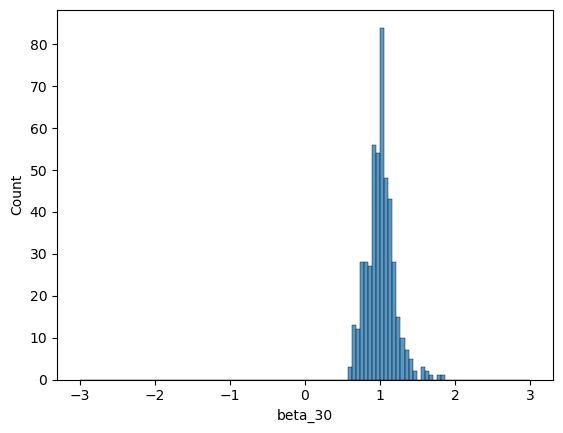

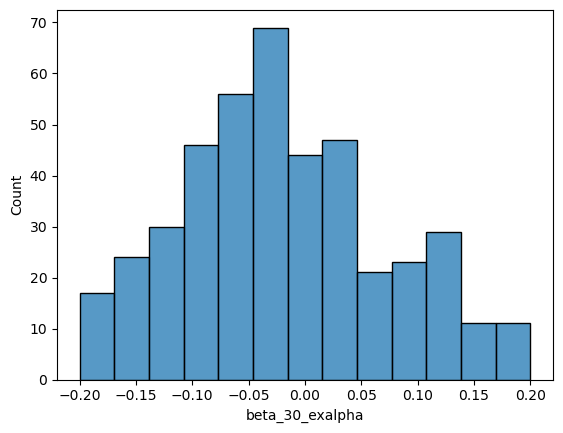

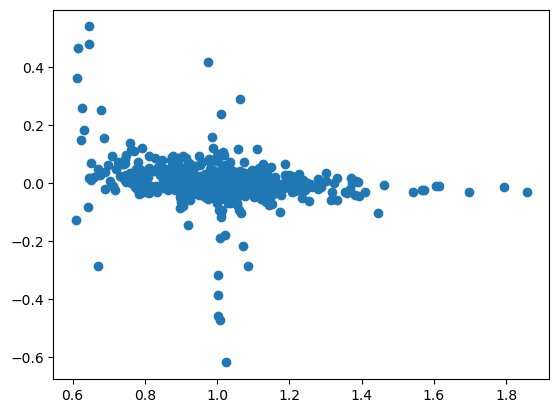

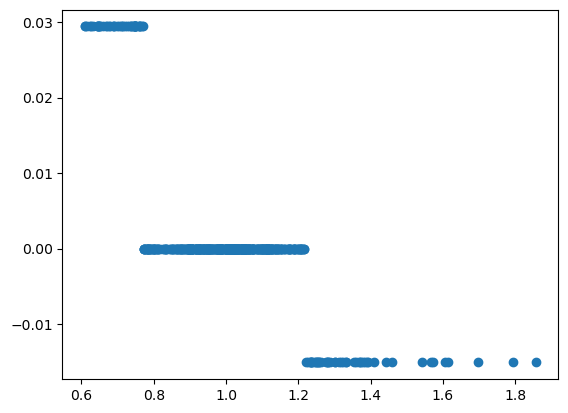

In [42]:
sns.histplot(investableStocks['beta_30'],binrange=(-3,3))
plt.show()
sns.histplot(investableStocks['beta_30_exalpha'],binrange=(-.2,.2))
plt.show()
plt.scatter(investableStocks['beta_30'],investableStocks['scaled_w'])
plt.show()
plt.scatter(investableStocks['beta_30'],investableStocks['wEqScaled'])
plt.show()